In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv("C:/Users/bodic/Downloads/Cholesterol_R2.csv")
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           18 non-null     int64  
 1   Before       18 non-null     float64
 2   After4weeks  18 non-null     float64
 3   After8weeks  18 non-null     float64
 4   Margarine    18 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 852.0+ bytes


(   ID  Before  After4weeks  After8weeks Margarine
 0   1    6.42         5.83         5.75         B
 1   2    6.76         6.20         6.13         B
 2   3    6.56         5.83         5.71         B
 3   4    4.80         4.27         4.15         A
 4   5    8.43         7.71         7.67         B,
 None)

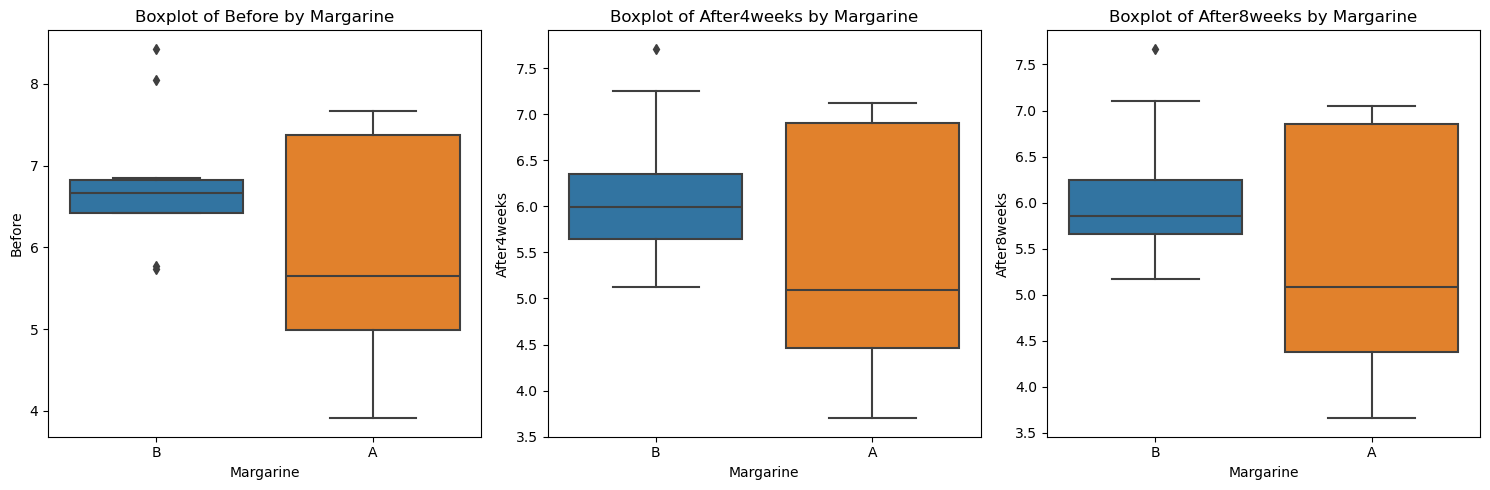

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, col in enumerate(["Before", "After4weeks", "After8weeks"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="Margarine", y=col, data=data)
    plt.title(f"Boxplot of {col} by Margarine")
    plt.xlabel("Margarine")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [13]:
def detect_outliers(df, group_col, value_col):
    outliers = []
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group][value_col]
        Q1 = group_data.quantile(0.25)
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group_outliers = group_data[(group_data < lower_bound) | (group_data > upper_bound)]
        outliers.extend(group_outliers.index)
    return list(set(outliers))

outlier_indices = {}
for col in ["Before", "After4weeks", "After8weeks"]:
    outlier_indices[col] = detect_outliers(data, "Margarine", col)

outlier_indices


{'Before': [8, 17, 4, 6], 'After4weeks': [4], 'After8weeks': [4]}

In [7]:
outlier_indices_to_remove = [4, 6, 8, 17]

data2 = data.drop(index=outlier_indices_to_remove)

print(data2)

    ID  Before  After4weeks  After8weeks Margarine
0    1    6.42         5.83         5.75         B
1    2    6.76         6.20         6.13         B
2    3    6.56         5.83         5.71         B
3    4    4.80         4.27         4.15         A
5    6    7.49         7.12         7.05         A
7    8    5.05         4.63         4.67         A
9   10    3.91         3.70         3.66         A
10  11    6.77         6.15         5.96         B
11  12    6.44         5.59         5.64         B
12  13    6.17         5.56         5.51         A
13  14    7.67         7.11         6.96         A
14  15    7.34         6.84         6.82         A
15  16    6.85         6.40         6.29         B
16  17    5.13         4.52         4.45         A


In [23]:
from scipy.stats import shapiro

normality_results = {}
for col in ["Before", "After4weeks", "After8weeks"]:
    normality_results[col] = {}
    for group in data2["Margarine"].unique():
        group_data = data2[data2["Margarine"] == group][col]
        stat, p_value = shapiro(group_data)
        normality_results[col][group] = {"Statistic": stat, "p-value": p_value}

normality_results

{'Before': {'B': {'Statistic': 0.8802617043459086,
   'p-value': 0.27026108499512935},
  'A': {'Statistic': 0.9005331050764726, 'p-value': 0.2921656660599702}},
 'After4weeks': {'B': {'Statistic': 0.9506978393562825,
   'p-value': 0.7459300387550575},
  'A': {'Statistic': 0.8710560626331322, 'p-value': 0.15435256420389698}},
 'After8weeks': {'B': {'Statistic': 0.9208518521296671,
   'p-value': 0.5115173757072288},
  'A': {'Statistic': 0.8763768978955019, 'p-value': 0.17383183631796062}}}

In [27]:
table_data = []
for variable, groups in normality_results.items():
    for group, results in groups.items():
        table_data.append({
            "Variable": variable,
            "Group": group,
            "Statistic": results["Statistic"],
            "p-value": results["p-value"]
        })

results_table = pd.DataFrame(table_data)

print(results_table)

      Variable Group  Statistic   p-value
0       Before     B   0.880262  0.270261
1       Before     A   0.900533  0.292166
2  After4weeks     B   0.950698  0.745930
3  After4weeks     A   0.871056  0.154353
4  After8weeks     B   0.920852  0.511517
5  After8weeks     A   0.876377  0.173832


In [43]:
from scipy.stats import levene

levene_results = []
for col in ["Before", "After4weeks", "After8weeks"]:
    group_a = data[data["Margarine"] == "A"][col]
    group_b = data[data["Margarine"] == "B"][col]
    stat, p_value = levene(group_a, group_b)
    levene_results.append({"Dependent Variable": col, "Statistic": stat, "p-value": p_value})

levene_results_df = pd.DataFrame(levene_results)

print(levene_results_df)


  Dependent Variable  Statistic   p-value
0             Before   4.399481  0.052190
1        After4weeks   4.175257  0.057847
2        After8weeks   4.718317  0.045217


In [53]:
from scipy.stats import chi2

def box_m_test(data2, group_column, dependent_columns):
    # Separate the data by groups
    groups = data[group_column].unique()
    cov_matrices = []
    group_sizes = []
    
    for group in groups:
        group_data = data2[data2[group_column] == group][dependent_columns]
        cov_matrices.append(np.cov(group_data, rowvar=False))
        group_sizes.append(len(group_data))
    
    pooled_cov = np.sum([(size - 1) * cov for size, cov in zip(group_sizes, cov_matrices)], axis=0) / (np.sum(group_sizes) - len(groups))
    
    num_groups = len(groups)
    num_vars = len(dependent_columns)
    
    m_statistic = 0
    for cov, size in zip(cov_matrices, group_sizes):
        diff_cov = cov - pooled_cov
        m_statistic += (size - 1) * np.log(np.linalg.det(cov)) - (size - 1) * np.log(np.linalg.det(pooled_cov))
    
    df = (num_groups - 1) * num_vars * (num_vars + 1) / 2
    
    p_value = 1 - chi2.cdf(m_statistic, df)
    
    return m_statistic, p_value

dependent_columns = ["Before", "After4weeks", "After8weeks"]
m_stat, p_value = box_m_test(data2, "Margarine", dependent_columns)

print(f"Box's M Statistic: {m_stat}")
print(f"p-value: {p_value}")

Box's M Statistic: -23.969847192466943
p-value: 1.0


***NARESET YUNG KERNEL KAYA NILOAD ULIT YUNG DATA SET HAHAHAHAHAHAHA***

In [41]:
import numpy as np
from scipy.stats import chi2
import pandas as pd

file_path = "C:/Users/bodic/Downloads/Cholesterol_R2.csv"
data = pd.read_csv(file_path)



def mauchly_test(data, dv, within, subject):

    wide_data = data.pivot(index=subject, columns=within, values=dv)
    time_points = wide_data.shape[1]

    covariance_matrix = wide_data.cov().values
    covariance_mean = np.mean(np.diagonal(covariance_matrix))

    determinant = np.linalg.det(covariance_matrix)
    trace_cov = np.trace(covariance_matrix)
    n_subjects = wide_data.shape[0]
    
    W = determinant / (covariance_mean ** time_points)
    df = (time_points * (time_points - 1)) // 2

    chi2_stat = - (n_subjects - 1) * np.log(W)

    p_value = chi2.sf(chi2_stat, df)
    
    return {"W": W, "Chi2": chi2_stat, "p-value": p_value, "df": df}



data_long = data.melt(id_vars=["ID", "Margarine"], 
                      value_vars=["Before", "After4weeks", "After8weeks"],
                      var_name="Time", value_name="Score")

mauchly_results = mauchly_test(data_long, dv='Score', within='Time', subject='ID')

mauchly_results



{'W': 5.272690862271966e-05,
 'Chi2': 167.4565387555124,
 'p-value': 4.505431399834455e-36,
 'df': 3}

In [55]:
print(data2)

    ID  Before  After4weeks  After8weeks Margarine
0    1    6.42         5.83         5.75         B
1    2    6.76         6.20         6.13         B
2    3    6.56         5.83         5.71         B
3    4    4.80         4.27         4.15         A
5    6    7.49         7.12         7.05         A
7    8    5.05         4.63         4.67         A
9   10    3.91         3.70         3.66         A
10  11    6.77         6.15         5.96         B
11  12    6.44         5.59         5.64         B
12  13    6.17         5.56         5.51         A
13  14    7.67         7.11         6.96         A
14  15    7.34         6.84         6.82         A
15  16    6.85         6.40         6.29         B
16  17    5.13         4.52         4.45         A
